## Disclaimer & Credits

In this kernel, I have attempted to re-implement the code for the third chapter of **Aurélien Géron's** amazing book [Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow](https://github.com/ageron/handson-ml2). You can find his detailed jupyter notebooks for each chapter in the link mentioned before. This notebook is primarily a way for me to internalize the content shared in each chapter of the book, and I hope it is useful to you. 


**Note:** _The code and content here is contained in the notebooks linked above. I have done my best not to include anything present in his book but not present in the notebooks._

### 1. MNIST Classifier with > 97% Accuracy

In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(42)

test = pd.read_csv("../input/mnist-in-csv/mnist_test.csv")
train = pd.read_csv("../input/mnist-in-csv/mnist_train.csv")

In [2]:
X_train, y_train = train.drop(labels=["label"],axis=1),  train["label"]
X_test, y_test = test.drop(labels=["label"],axis=1),  test["label"]

In [3]:
X_train = X_train.values.reshape(-1, 784)
X_test = X_test.values.reshape(-1, 784)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
param_grid = [{'weights': ["distance"], 'n_neighbors': [3, 4, 5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 93.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5], 'weights': ['distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [5]:
# What are the best parameters?
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [6]:
# What's the best score?
grid_search.best_score_

0.9716166666666666

In [7]:
# Did we achieve the target?
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

### 2. Data Augmentation and Re-evaluation

In [8]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

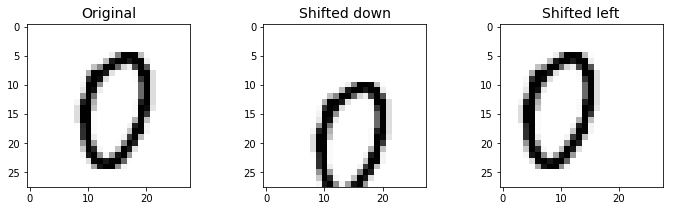

In [9]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [10]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [11]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [12]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [13]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [14]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763